In [512]:
from functools import partial

import cvxpy as cp

import matplotlib.pyplot as plt

import numpy as np




In [513]:
# ------- CONSTANTS ------- #

n = 6 # state dimension
m = 3 # control dimension
T = 300 # total time
N = 7 # MPC horizon
dt = 1
mass = 1.0 # Mass
mean_motion = 1
rho = 20
max_iters = 50 # maximum SCP iterations
eps = 0.5 # convergence tolerance
u_max = 1000 # control effort bound

P = 1e3*np.eye(n)                    # terminal state cost matrix
Q = np.diag([1., 1, 1, 1e-3, 1e-3, 1e-3])
# Q = np.diag([1e-1, 1e-1, 1e-1, 1e-2, 1e-2, 1e-2])  # state cost matrix
R = 1e-3*np.eye(m)  


s_start = np.array([50, 50, 50, 0, 0, 0]) # x, y, z, dx, dy, dz
s_goal = np.array([5e5, 5e10, 5e10, 0, 0, 0]) # location of target in space



In [514]:

# ------- DYNAMICS -------- #
def state_space(T, n, m):
    # CWH equations for state space
    A = np.matrix([[4 - 3*np.cos(n*T), 0, 0, 1/n*np.sin(n*T), 2/n*(1-np.cos(n*T)), 0],
                  [6*(np.sin(n*T)-n*T), 1, 0, 2/n*(np.cos(n*T)-1), 1/n*(4*np.sin(n*T)-3*n*T), 0],
                  [0, 0, np.cos(n*T), 0, 0, 1/n*np.sin(n*T)],
                  [3*n*np.sin(n*T), 0, 0, np.cos(n*T), 2*np.sin(n*T), 0],
                  [6*n*(np.cos(n*T)-1), 0, 0, -2*np.sin(n*T), 4*np.cos(n*T)-3, 0],
                  [0, 0, -n*np.sin(n*T), 0, 0, np.cos(n*T)]])
    
    B = 1/m*np.matrix([[1/n**2*(1-np.cos(n*T)), 2/n**2*(n*T - np.sin(n*T)), 0],
                     [-2/n**2*(n*T - np.sin(n*T)), 4/n**2*(1-np.cos(n*T))-3/n*T, 0],
                     [0, 0, 1/n**2*(1-np.cos(n*T))],
                     [1/n*np.sin(n*T), -2/n*(np.cos(n*T)-1), 0],
                     [2/n*(np.cos(n*T)-1), 4/n*np.sin(n*T)-3/n*T, 0],
                     [0, 0, 1/n*np.sin(n*T)]])

    return (A, B)

def dynamics(N, mean_motion, mass):
    
    A = []
    B = []

    for k in range(N):
        # print("hi")
        Anew, Bnew = state_space(k, mean_motion, mass)
        A.append(Anew)
        B.append(Bnew)
        
    return (A, B)



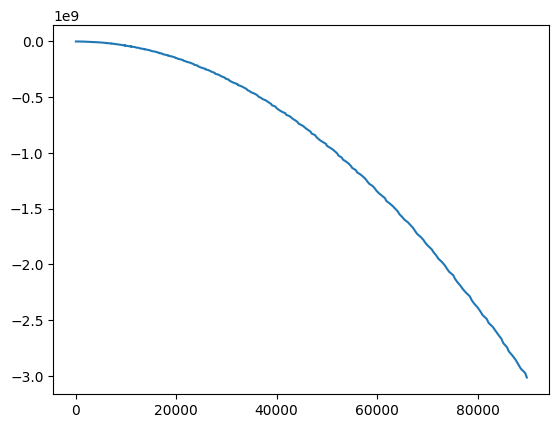

In [515]:
#Understanding CWH equations
orbit = 300
A, B = dynamics(orbit, mean_motion, mass)
x_current = s_start
xs = []
for k in range(orbit):
    x_next = np.array(A[k]@x_current + B[k]@np.array([1, 1, 1])).flatten()
    xs.append(x_next)
    x_current = x_next

plt.plot([x[0] for x in xs], [x[1] for x in xs])

In [516]:
# ------- SCP Problem Definition -------- #
A, B = dynamics(T, mean_motion, mass)

n = Q.shape[0]
m = R.shape[0]

s_cvx = cp.Variable((N + 1, n))
u_cvx = cp.Variable((N, m))

s0 = cp.Parameter(n)
s0.value = s_start

print(s_cvx.shape)
print(u_cvx.shape)

# Construct the convex SCP sub-problem.
objective = cp.quad_form((s_cvx[N] - s_goal), P) + cp.sum([(cp.quad_form((s_cvx[k] - s_goal), Q) + cp.quad_form(u_cvx[k], R)) for k in range(N)])
constraints = [s_cvx[0] == s0]
constraints += [(s_cvx[k + 1] == A[k]@s_cvx[k] + B[k]@u_cvx[k]) for k in range(N)]


prob = cp.Problem(cp.Minimize(objective), constraints)

(8, 6)
(7, 3)


In [517]:

# ------- SCP Iteration -------- #
def scp_iteration(s_new, u_new):
    # s_cvx.value = s_new
    # u_cvx.value = u_new
    prob.solve(warm_start=True)

    return s_cvx.value, u_cvx.value, prob.objective.value

# ------- SCP Solve-------- #
def scp_solve(max_iters, eps, s_init, u_init):
    s = np.copy(s_init)
    u = np.copy(u_init)

    converged = False
    J = np.zeros(max_iters + 1)
    J[0] = np.inf

    count = 0
    for i in range(max_iters):
        s, u, J[i + 1] = scp_iteration(s, u)
        dJ = np.abs(J[i + 1] - J[i])
        count += 1
        if dJ < eps:
            converged = True
            break
    print(f"Converged in {count} iterations")
    
    if not converged:
        raise RuntimeError('SCP did not converge!')
    return s, u



In [518]:
def straight_line_traj(s_start, s_goal, T):
    n = s_start.shape[0]
    # Generate a straight line trajectory from s_start to s_goal.
    s = np.zeros((T + 1, n))
    for k in range(T + 1):
        s[k] = s_start + (s_goal - s_start)*k/T
    sx = s[:, 0]
    sy = s[:, 1]
    sz = s[:, 2]
    vx = np.diff(sx)
    vy = np.diff(sy)
    vz = np.diff(sz)
    vx = np.append(vx, vx[-1])
    vy = np.append(vy, vy[-1])
    vz = np.append(vz, vz[-1])

    s = np.hstack((sx[:, None], sy[:, None], sz[:, None], vx[:, None], vy[:, None], vz[:, None]))
    # plt.plot(sx[:, None], sy[:, None], 'k--')
    
    return s

Converged in 30 iterations
[[ 9.84764754e+24 -1.33477386e+25  4.95692748e+13]
 [ 9.84764754e+24 -1.33477386e+25  4.95692748e+13]
 [ 7.99507139e+23 -1.63396404e+24  2.11390792e+11]
 [-5.38969554e+24  7.93489421e+23 -5.56406610e+10]
 [-4.18490564e+24 -9.06089503e+23  2.67155079e+06]
 [ 8.71787878e+23 -4.89777561e+23  2.75164035e+11]
 [ 1.28540294e+24  1.15827861e+23 -5.51121519e+11]
 [ 4.54868845e+21  7.31603570e+19  5.04472152e+10]]
---
[ 9.84764754e+24 -1.33477386e+25  4.95692748e+13]
Converged in 3 iterations
[[ 9.84764754e+24 -1.33477386e+25  4.95692748e+13]
 [ 9.84764754e+24 -1.33477386e+25  4.95692748e+13]
 [ 7.99507139e+23 -1.63396404e+24  2.11390792e+11]
 [-5.38969554e+24  7.93489421e+23 -5.56406610e+10]
 [-4.18490564e+24 -9.06089503e+23  2.67155079e+06]
 [ 8.71787878e+23 -4.89777561e+23  2.75164035e+11]
 [ 1.28540294e+24  1.15827861e+23 -5.51121519e+11]
 [ 4.54868845e+21  7.31603570e+19  5.04472152e+10]]
---
[ 7.99507139e+23 -1.63396404e+24  2.11390792e+11]
Converged in 50 itera

RuntimeError: SCP did not converge!

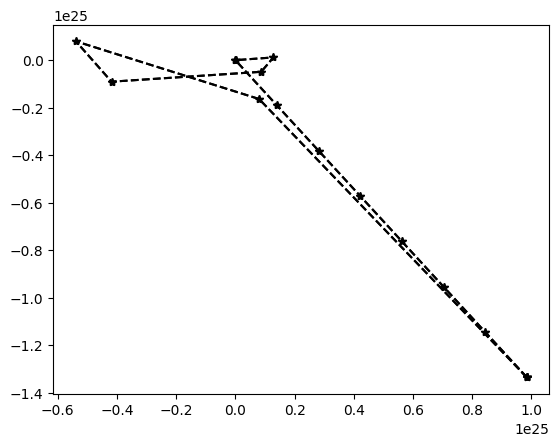

In [521]:
# ------- MPC -------- #
s_mpc = np.zeros((T, N + 1, n))
u_mpc = np.zeros((T, N, m))

for t in range(T):
    # Generate a straight line trajectory from s_start to s_goal for MPC Horizon length
    s_init = straight_line_traj(s0.value, s_goal, N)
    u_init = np.zeros((N, m))

    # print(s_init.shape)
    s_mpc[t], u_mpc[t] = scp_solve(max_iters, eps, s_init, u_init)
    
    status = prob.status
    if status == 'infeasible':
        s_mpc = s_mpc[:t]
        u_mpc = u_mpc[:t]
        print('MPC problem is infeasible!')
        break 
    
    
    s0.value = np.array(A[t]@s_mpc[t, 1, :] + B[t]@u_mpc[t, 1, :]).flatten()
    # s0.value = s_mpc[t, 1, :]
    print(s_mpc[t, :, 0:3])
    print('---')
    print(s0.value[0:3])


    plt.plot(s_mpc[t, :, 0], s_mpc[t, :, 1], '--*', color='k')
    plt.plot(s_init[:, 0], s_init[:, 1], '--*', color='k')


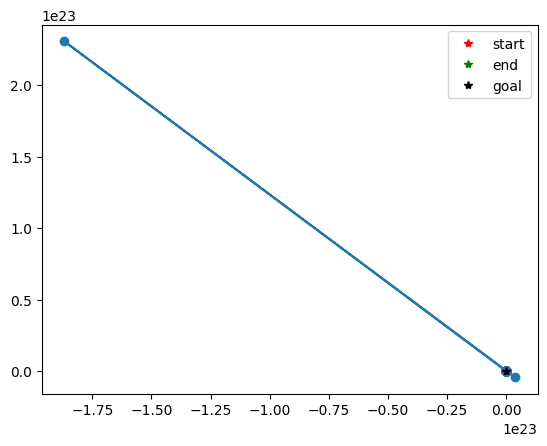

In [520]:

# ------- Plotting -------- #
plt.figure()
plt.plot(s_mpc[:, 0, 0], s_mpc[:, 0, 1], '-o')
# plot starting point and goal
plt.plot(s_mpc[0, 0, 0], s_mpc[0, 0, 1], '*', color='r', label='start')
plt.plot(s_mpc[-1, 0, 0], s_mpc[-1, 0, 1], '*', color='g', label='end')
plt.plot(s_goal[0], s_goal[1], '*', color='k', label='goal')
plt.legend()
plt.show()



In [ ]:
# # ------- INITIALIZE STRAIGHT LINE TRAJECTORY -------- #
#     # convert to spherical coordinates
#     rho = np.sqrt(s0.value[0]**2 + s0.value[1]**2 + s0.value[2]**2)
#     theta = np.arccos(s_start[2]/rho)
#     phi = np.arctan2(s_start[1], s_start[0])

#     # create straight line trajectory
#     r_final = np.sqrt(s_goal[0]**2 + s_goal[1]**2 + s_goal[2]**2)
    
#     rho_traj = np.linspace(rho, r_final, N + 1)
    
#     sx_traj = [rho_traj[k]*np.sin(theta)*np.cos(phi) for k in range(N + 1)]
#     sy_traj = [rho_traj[k]*np.sin(theta)*np.sin(phi) for k in range(N + 1)]
#     sz_traj = [rho_traj[k]*np.cos(theta) for k in range(N + 1)]

#     vx_traj = [(sx_traj[k+1] - sx_traj[k]) for k in range(N)] + [0]
#     vy_traj = [(sy_traj[k+1] - sy_traj[k]) for k in range(N)] + [0]
#     vz_traj = [(sz_traj[k+1] - sz_traj[k]) for k in range(N)] + [0]